In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

### Time Series Analysis and Forecasting

Case study: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b <br>
data: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls <br>
Classical approaches to time-series: https://towardsdatascience.com/lets-forecast-your-time-series-using-classical-approaches-f84eb982212c <br>

### Plan: 
- Data Processing
- Time Series components
- Forecasting with ARIMA
- Forecasting with Prophet

### Intro
- Time Series - a series of data points indexed in time order; a time series is a sequence taken at successive equally spaced points in time
- depending on the frequency, a time series can be yearly, quarterly, monthly, etc
- Types
    - stationary - white noise (remainder) - a constant long-term mean and a cosntant variance independent of time
    - not stationary - time series with trends or seasonality - a variable variance and a mean that doesn't remain near - at any point in time values differ due to seasonality and trend
- How to make non-stationary time series stationary - compute the differences between consecutive observations

### Load Data

In [2]:
# first import xlrd
df = pd.read_excel("P:\ds-moni\TimeSeries\Superstore.xls")
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [33]:
# let's start with furniture sales
furniture = df.loc[df['Category'] == 'Furniture'].reset_index(drop=True)

In [34]:
furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [18]:
# 4-year furniture sale data - Jan 2014 to Dec 2017
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [19]:
furniture[:2]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


### Data Processing
- To Do:
- before dropping the columns do EDA

In [35]:
# remove columns we do not need
cols_to_drop = [x for x in furniture.columns if x not in ['Order Date','Sales']]
furniture.drop(cols_to_drop, axis=1, inplace=True)

# check for nulls
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [36]:
# group up sales by date
furniture = furniture.groupby(['Order Date'])['Sales'].sum().reset_index()
furniture[:3]

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940


In [37]:
# set date as index
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [38]:
# the current daily data can be tricky to work with,
# therefore, we will use the average daily sales value for that month instead
# use start of each month as the timestamp

# 
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation
# resampling the data based on frequency - MS: month start frequency
y = furniture['Sales'].resample('MS').mean()
y['2017':][:5]

Order Date
2017-01-01    397.602133
2017-02-01    528.179800
2017-03-01    544.672240
2017-04-01    453.297905
2017-05-01    678.302328
Freq: MS, Name: Sales, dtype: float64

In [35]:
y.describe()

count      48.000000
mean      784.081373
std       306.873209
min       356.868273
25%       558.061703
50%       707.539737
75%       978.801722
max      1532.298325
Name: Sales, dtype: float64

### Time Series Components 

<AxesSubplot:xlabel='Order Date'>

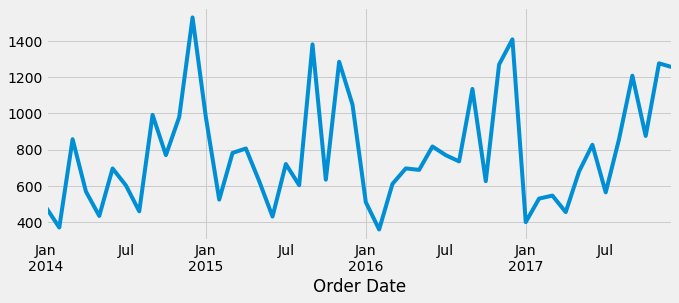

In [34]:
y.plot(figsize=(10,4))

##### It looks like the data has seasonality pattern - sales are always low at the beginning of the year and high at the end of the year. There are 2 peaks in the 2nd half of each year.

#### Decompose the time series data into distinct components - break data into individual elements:
- **trend** - the general direction of the time series data <br>
    E.g Our data doesn't look to have a significant trend
- **seasonality** - patterns that frequently repeat themselves <br>
    E.g The data has seasonal pattern 
- **noise/randomness** - random fluctuations in a time series or this is the remainder <br>
    E.g what's left after the seasonal and trend components have been subtracted from the data
- **cycle** - the data has a frequency to rise and fall at inconsistent frequencies - cycles

#### Types of Decomposition techniques
- Classical decomposition 
    - the starting point for most other methods of time series decomposition
    - an additive and a multiplicative decomposition
    - assume that the seasonal component is constant from year to year
    - for longer time series this is not a reasonable assumption
    
- X11 decomposition
    - based on classical decomposition
    - extra features that overcome the drawbacks in the classical approach
    - the seasonal component varies slowly over time
    - trend-cycle estimates are available for all observations
    - can handle trading days, holiday effects, etc
    - both additive nad multiplicative forms
    - robust to outliers and level shifts

- SEATS decomposition - Seasonal Extraction in ARIMA Time Series
    - developed by the Bank of Spain and widely used by government agencies around the world
    - works only with monthly or quarterly data
    - so seasonality of other kinds,daily, hourly, etc require an alternatve approach
    - similar to X11
    
- STL decomposition - Seasonal and Trend decomposition using Loess
    - Advantages
        - unlike SEATS and X11, it an handle any type of seasonality - not only monthly and quarterly data
        - the seasonal component is allowed to change over time, and the rate of change can be controlled by the user
        - the smoothness of the trend-cycle can also be controlledby the user
        - robust to outliers so that occassional unusual observations will not affect the estimates of the trend cycle and seasonal components. They affect the remainder
    - Disadvantages
        - unlike SEATS and X11 it doesn't handle trading days or calendar variations automatically
        - only provide facilities for additive decomposition
        - it is still possible to do multiplicative decomposition but first take data must be transformed

#### STL decomposition - Seasonal and Trend decomposition using Loess

Text(0.5, 1.0, 'Noise')

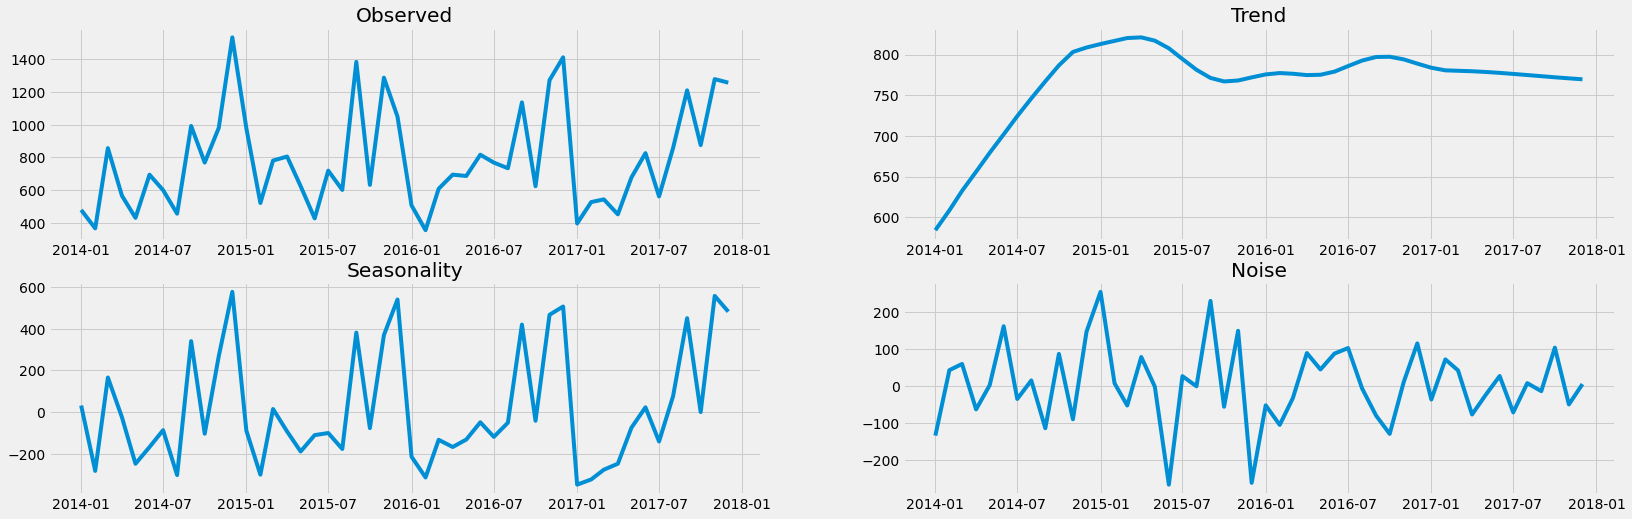

In [92]:
from statsmodels.tsa.seasonal import STL

stl = STL(y,seasonal=13)
res = stl.fit()

fig, ax = plt.subplots(2,2,figsize=(25,8))

ax[0,0].plot(y)
ax[0,0].set_title('Observed')
ax[0,1].plot(res.trend)
ax[0,1].set_title('Trend')
ax[1,0].plot(res.seasonal)
ax[1,0].set_title('Seasonality')
ax[1,1].plot(res.resid)
ax[1,1].set_title('Noise')

These components can be added together to reconstruct the top left plot - observed. <br>

**Trend** - there is an upward trend until 2015 and then the line flattens. After 2015 the sales stopped increasing; <br>

**Seasonality** - clearly we see there is seasonal pattern every 2nd half of each year. There are two peaks; <br> 

**Noise** - this is what's left after we remove the trend and the seasonality. It is similar to pure chance. The expectations from the remaidner is that it shouldn't display any pattern. It should look a low like white noise -  time series that show no autocorrelation. White noise has a wide application in time series modelling. ARIMA tries to make the remainder look a lot like white noise. 

#### Autocorrelation 
https://campus.datacamp.com/courses/time-series-analysis-in-python/some-simple-time-series?ex=1
- measures the relationship between a variable's current value and its past values

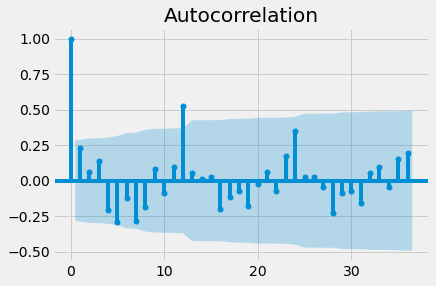

In [99]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(y, lags=36, alpha=0.05)

- at 0 we've got the correlation at time t with itself
- at 1 - time t with time t-1, current and previous value, etc
- if the autocorrelation is outside the confidence intervals then it differs significantly from 0
- the plot shows correlation at lags 12,24,36; this is showing 2 things
    - annual pattern in the data
    - since the autocorrelation at lag 12 differ from 0 significantly we can predict the next vaue of the series from the values at lag 12 
- the more we go back in time the smaller the autocorreltion

### Forecasting with ARIMA - Autoregressive Integrated Moving Average
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=So%20what%20exactly%20is%20an,used%20to%20forecast%20future%20values <br>
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

**1. What is ARIMA?**
- one of the two most widely used approaches to time series forecasting (together with exponential smoothing)
- a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to rpedcit the future values - univariate time series forecasting 
- any non-seasonal time series that exhibits patterns and is not a random white noise can be modelled with ARIMA
- if a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA

**2. How does it work?**
- a combination of autoregressive - AR, and moving average - MA, models
- AR model - one where the outcome/response var depends only on its own lags or its previous values
- MA model - one where the response variable depends only on the past forecast errors
- ARIMA model is one where the time series is differenced at least once to make it stationary (ARIMA tends to describe the autocorrelations in the data) and you combine the AR and the MA terms
- Predicted y = Constant + Linear combination of past values (up to p lags) + Linear combination of past forecast errors (up to q lags)
- the objective therefore is to identify the values of p,d, and q

**3. ARIMA terms**
- ARIMA can be characterized by 3 terms:
    - p - order of the AR term
    - q - order of the MA term
    - d - the number of differencing required to make the time series stationary
- SARIMA has non-seasonal and seasonal elements of the series:
    - non-seasonal elements are the same as the ARIMA model: p - AR term, q - MA term, d - difference term 
    - 4 seasonal elements that are not part of ARIMA: P - seasonal AR; Q - seasonal MA, D - seasonal difference term, m - number of time steps for a single seasonal period

<img src="ARIMA.PNG" width="600" />

#### Define the parameters grid

In [105]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # all possible combinations or the cartesian product
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


#### Grid search to find the optimal set of parameters 

In [107]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1616.3112802595379
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793669
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1251.1758366451986
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.248828030213
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2666.8381642858894
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091625

C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673279


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.56719909184096
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2499.983100280788
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946866
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576570792
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766859465
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.1933114315284
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671879367


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679584
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1308.0103498737485
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.91132001514455
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817272


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:821.8566690730896
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482972
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233340705
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.183297744263


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1745.0089564869636
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417337
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461242
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1400.1891980979801
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160952
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679352024
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1252.156331011107
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.46646750845787
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.5842692143849
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186199


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2423.120494426991
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815885
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939658977
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877136


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2368.2505005684898
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002198767
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188112624
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1287.4915737951865
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.21306116190993
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658785467


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1248.440435404364
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345424
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.3264992507372
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835522


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1303.4925034107116
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610234
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.38730069394046
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546608096


C:\Users\astas\Miniconda3\envs\training\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2502.5614996229415
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439537219
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.36610144744895


##### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. 
- AIC - Akaike information criterion - tells you how well a model performs

#### Fitting the model

In [109]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


#### Interpreting the results 
https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c <br>
Sigma2 is the variance of the residuals. ar.L1 is the AR term with the lag of 1 and ma.L2 is the MA term with the lag of 1; ar.S.L12 is the seasonal AR term witht he lat fo 12. 
- std error - how strong is the effect o the residual error on the estimated parameters
- if any of the p-values > 0.05 we might be using an unreliable coefficient that might cause misleading results. 
    - only ma.L1 is reliable
- coef - significance of each feature - how much the output changes for a unit change in the input variables

<AxesSubplot:title={'center':'Residuals'}, xlabel='Order Date'>

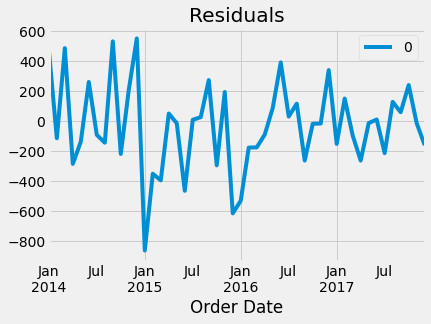

In [138]:
residuals = pd.DataFrame(results.resid)

residuals.plot(title="Residuals")

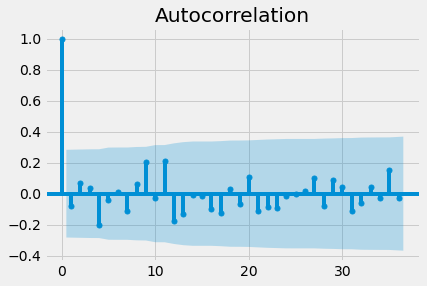

In [139]:
fig = plot_acf(results.resid, lags=36, alpha=0.05)

##### Results: no significant correlation between residuals and the residuals do not have a trend or seasonality, which is good

### Validate Forecasts
- let's understand more the accuracy of the model 
- predict sales for Jan 2017 onwards and compare with real data

In [144]:
pred.predicted_mean.plot(ax=ax,)

<AxesSubplot:xlabel='Order Date', ylabel='Furniture Sales'>

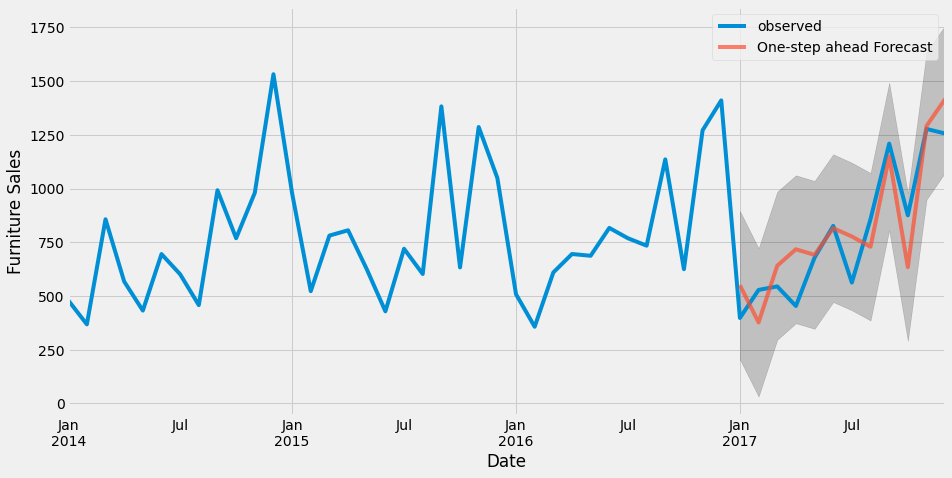

In [140]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# fill the area between two curves
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

##### Results: Observed values compared to the rolling forecast; Overall our forecasts aligh well with the true values showing an upward trend starting from Jan 2017 and captured the seasonality towards the end of the year

In [146]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 22993.57
The Root Mean Squared Error of our forecasts is 151.64


##### RMSE - tells us that our model was able to forecast the avg daily sales within 151.64 of the real real sales. 

### Prophet Modelling
https://medium.com/analytics-vidhya/how-does-prophet-work-44addaab6148 <br>

1. What is Prophet?
    - a forecasting Facebook tool released 2017
    - prophet deoesn't require much prior knowledge or experience of forecasting time series since automatically finds seasonal trends and offers a set of parameters
    - includes many different forecasting technique - ARIMA, exponential smoothing, etc
    - has 4 main components
        - linear or logistic growth curve trend - automatically detects changes in trends by selecting changepoints from the data
        - yearly seasonal component modeled using Fourier series
        - a weekly seasonal component using dummy variables
        - a user-provided list of important holdiays
    - Prophet works through use of an additive model whereby the non-linear trends in the series are fitted with the appropriate seasonality (whether daily, weekly, or yearly).
    - it implements 2 possible models - logistic growth model and piecewise linear model
    - One key difference between ARIMA and Prophet is that the Prophet model accounts for “change points” - specific shifts in trend in the time series


<img src="PROPHET.PNG" width="600" />

2. Prophet is optimized for forecast tasks encountered at FB
    - data should have at least a few months preferable a year of points
    - good for strong multiple seasonality - day of week and time of year
    - important holidays known in advance
    - deals well with a reasonable number of missing observations or large outliers
    - historical trend changes - product launches, logging changes, etc
    - has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints

#### Installing Prophet
https://github.com/facebook/prophet/issues/892 <br> 

Follow the steps:

On Prompt install Ephem:
conda install -c anaconda ephem

Install Pystan:
conda install -c conda-forge pystan

Finally install Fbprophet
conda install -c conda-forge fbprophet

Installing conda install -c conda-forge fbprophet straight away doesn't work

In [53]:
train = y['2014':'2016']
test = y['2017':]

In [54]:
train = pd.DataFrame(train).reset_index()
# input columns have to be names ds and y
train = train.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

test = pd.DataFrame(test).reset_index()
test = test.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [55]:
from fbprophet import Prophet

# initiate the prophet object
# set the uncertainty interval to 95% (the Prophet default is 80%)
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
# a new dataframe that holds the dates for which we want predictions
# automatically created by prophet
# instruct prophet to create 12 datestamps in the future
# we are looking to rpedict future values of our time series data 1 year into the future - 2017
# MS - start of the month
furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
furniture_forecast.tail()

,ds
43,2017-08-01
44,2017-09-01
45,2017-10-01
46,2017-11-01
47,2017-12-01


In [73]:
# make predictions
# yhat-forecasted value
# yhat_lower - the lower bound of our forecasts
# yhat_upper - the upper bound of our forecasts
# these variations are expected as prophet relies on Markov Chain Monte Carlo to geenrate the forecasts
furniture_forecast = furniture_model.predict(furniture_forecast)
furniture_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:3]

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,634.139383,409.188170,856.620285
1,2014-02-01,411.560089,201.693856,631.768551
2,2014-03-01,731.724707,488.620817,947.160205


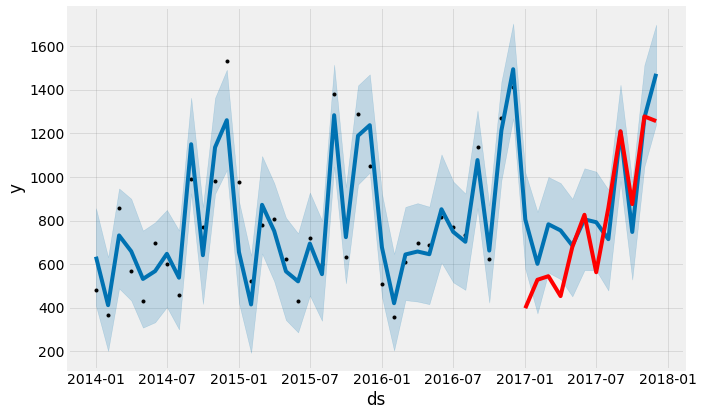

In [76]:
furniture_model.plot(furniture_forecast, uncertainty=True)
plt.plot(test['ds'],test['y'], c='r')

#### Results: 
- the black dots are the real values
- the forecasted values are the blue line
- we are given the uncertainty intervals as well
- red line is the observed test data

In [100]:
test_forecasted = furniture_forecast[-12:].reset_index()['yhat']
mse = ((test_forecasted - test['y']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 37992.52
The Root Mean Squared Error of our forecasts is 194.92


#### Compnents
- Prophet returns the components ofour forecasts
- reveals daily, weekly and yearly patterns of the time series to see how they contribute to the overall forecasted values

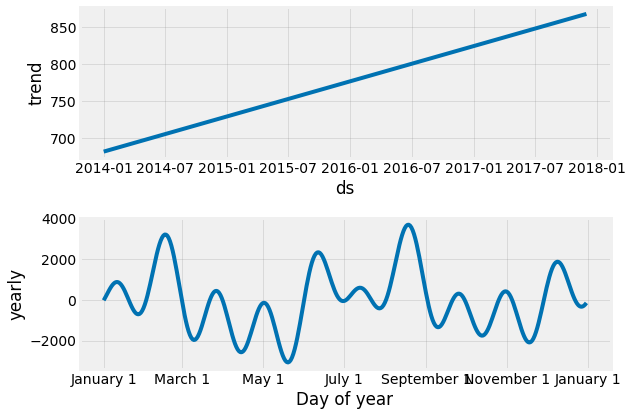

In [104]:
fig = furniture_model.plot_components(furniture_forecast)